<a href="https://colab.research.google.com/github/hungpham13/Face-mask-detection/blob/main/PRJ1_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/hungpham13/Face-mask-detection.git

Cloning into 'Face-mask-detection'...
remote: Enumerating objects: 1718, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1718 (delta 1), reused 0 (delta 0), pack-reused 1716
Receiving objects: 100% (1718/1718), 394.58 MiB | 31.10 MiB/s, done.
Resolving deltas: 100% (850/850), done.
Checking out files: 100% (1709/1709), done.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from bs4 import BeautifulSoup
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
from PIL import Image

In [ ]:
annotation_dir = "./Face-mask-detection/data/annotations/"
image_dir = "./Face-mask-detection/data/images/"

## Extract data from XML files

In [ ]:
label_to_int = {'without_mask':0,'mask_weared_incorrect':1,'with_mask':2}

def get_annotation(xml_file):
    with open(xml_file) as f:
        soup = BeautifulSoup(f.read(), 'xml')
        objects = soup.find_all('object')

        boxes,label_int = [],[]
        info = {}
        for obj in objects:
            label_int.append(label_to_int[obj.find('name').text])
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            xmax = int(obj.find('xmax').text)
            ymax = int(obj.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
        # convert to tensor
        info['boxes'] = torch.as_tensor(boxes, dtype = torch.float32)
        info['label'] = torch.as_tensor(label_int, dtype = torch.int64)
        return info

class MaskDataset(Dataset):
    def __init__(self, transform):
        self.transform = transform
        self.imgs = sorted([n for (d,_,n) in os.walk(image_dir)][0])

    def __getitem__(self,idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(image_dir, file_image)
        label_path = os.path.join(annotation_dir, file_label)
        img = Image.open(img_path).convert("RGB")
        #Get Label
        label = get_annotation(label_path)
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor() #normalize the size of image to [0,1]
])

def unzip_batch(batch):
    '''unzip the batch to individual pairs
    from (img1,img2,..),(label1,label2,...) to (img1,label1),(img2,label2),....
    '''
    return list(zip(*batch))

data = MaskDataset(transform)
data_loader = DataLoader(data, batch_size=5, collate_fn=unzip_batch)

Feature batch shape: torch.Size([3, 366, 512])
Labels batch : {'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]]), 'label': tensor([0, 2, 0])}


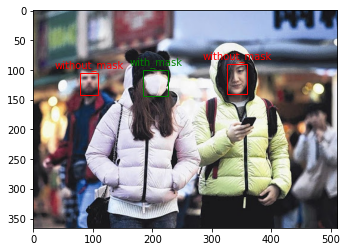

Feature batch shape: torch.Size([3, 156, 400])
Labels batch : {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]]), 'label': tensor([2, 2, 2, 2, 2, 2, 2, 2, 0])}


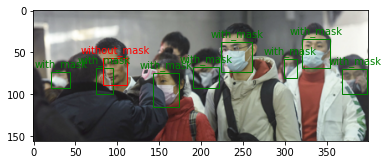

Feature batch shape: torch.Size([3, 290, 400])
Labels batch : {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]]), 'label': tensor([2, 2, 2, 1])}


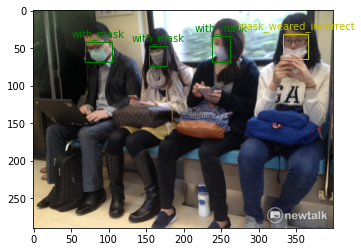

Feature batch shape: torch.Size([3, 271, 400])
Labels batch : {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
        [112.,  51., 120.,  68.],
        [155.,  60., 177.,  83.],
        [189.,  59., 210.,  80.],
        [235.,  57., 257.,  78.],
        [289.,  60., 309.,  83.],
        [313.,  68., 333.,  90.],
        [351.,  35., 364.,  59.]]), 'label': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2])}


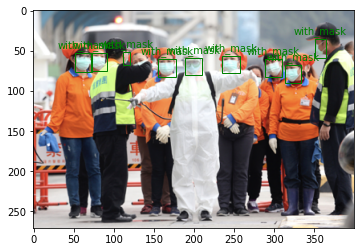

Feature batch shape: torch.Size([3, 400, 301])
Labels batch : {'boxes': tensor([[ 70., 185., 176., 321.]]), 'label': tensor([2])}


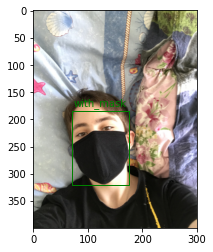

In [ ]:
def plot_image(img_tensor, annotation):
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data
    int_to_lc = {0:['without_mask','r'],1:['mask_weared_incorrect','y'],2:['with_mask','g']}

    # Display the image
    ax.imshow(img.permute(1, 2, 0))

    for i,box in enumerate(annotation['boxes']):
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        label, color = int_to_lc[int(annotation['label'][i])]
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color,facecolor='none')
        ax.annotate(label,color=color,
                    xy = (xmin+(xmax-xmin)/2,ymin), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 8), 
                    textcoords = 'offset points')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()


img_batch, label_batch = next(iter(data_loader))

for img,label in zip(img_batch,label_batch):
    print(f"Feature batch shape: {img.size()}")
    print(f"Labels batch : {label}")
    plot_image(img, label)

## check for error in annotation dataframe

In [ ]:
annotations_df.info()

NameError: ignored

In [ ]:
annotations_df.groupby('label')['image'].describe()
#grammartically correct

# Material
https://www.freecodecamp.org/learn/machine-learning-with-python/tensorflow/neural-networks-creating-a-model



https://github.com/bluewarrior-soda/Algorithm-Bootcamp-Scholarship/blob/main/Personal%20Projects/Deep%20Learning%20Final%20Project/notebooks/%231%20-%20Data%20Extraction.ipynb

In [ ]:
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'width': [], 'height': [], 'image':[]}

for annotation in glob.glob(annotation_dir + '/*.xml'):
    root = ElementTree.parse(annotation).getroot()
    for attribute in root.iter('width'):
        width = int(round(float(attribute.text)))
    for attribute in root.iter('height'):
        height = int(round(float(attribute.text)))    
    for attribute in root.iter('filename'):
        image = attribute.text

    for element in root.iter('object'):
        for attribute in list(element):
            # Get Label (Target Variable), Image Width & Height, And Image File Name
            if 'name' in attribute.tag:
                information['label'].append(attribute.text)
                information['width'].append(width)
                information['height'].append(height)
                information['image'].append(image)
            # Get The Dimension (xmin, ymin, xmax, ymax)
            if 'bndbox' in attribute.tag:
                for dimension in list(attribute):
                    information[dimension.tag].append(int(round(float(dimension.text))))

annotations_df = pd.DataFrame(information)
annotations_df.head(10)

NameError: ignored